# 推荐系统之DeepWalk
主要思想：在由物品组成的图结构上进行随机游走，产生大量物品序列，然后将这些物品序列作为训练样本输入Word2vec进行训练，得到物品Emmbedding。  
算法流程：  

![](./imgs/算法流程.jpg)  

(a)原始用户行为序列;  
(b)基于这些用户行为序列构建物品关系图；  
(c)采用随机游走的方式随机选择起始点，重新产生物品序列；  
(d)将这些物品序列输入到Word2Vec模型中,生成最终的Embedding向量。

# DeepWalk设计

In [27]:
class DeepWalk:
    
    def __init__(self, graph, walk_length, num_walks, workers=1):

        self.graph = graph
        self.w2v_model = None
        self._embeddings = {}

        self.walker = RandomWalker(
            graph, p=1, q=1, )
        self.sentences = self.walker.simulate_walks(
            num_walks=num_walks, walk_length=walk_length, workers=workers, verbose=1)

    def train(self, embed_size=128, window_size=5, workers=3, iter=5, **kwargs):

        kwargs["sentences"] = self.sentences
        kwargs["min_count"] = kwargs.get("min_count", 0)
        kwargs["size"] = embed_size
        kwargs["sg"] = 1  # skip gram
        kwargs["hs"] = 1  # deepwalk use Hierarchical Softmax
        kwargs["workers"] = workers
        kwargs["window"] = window_size
        kwargs["iter"] = iter

        print("Learning embedding vectors...")
        model = Word2Vec(**kwargs)
        print("Learning embedding vectors done!")

        self.w2v_model = model
        return model

    def get_embeddings(self,):
        if self.w2v_model is None:
            print("model not train")
            return {}

        self._embeddings = {}
        for word in self.graph.nodes():
            self._embeddings[word] = self.w2v_model.wv[word]

        return self._embeddings

## 随机游走策略
随机游走图:  
![](./imgs/deepwalk.svg)

In [21]:
def deepwalk_walk(self, walk_length, start_node):
    """
    结点的随机游走路径
    walk_length: 游走长度
    start: 起始结点
    return: 游走路径
    """
    
    walk = [start_node]
    while len(walk) < walk_length:
        cur = walk[-1]  # 当前结点,每次都以当前结点进行创建
        cur_nbrs = list(self.G.neighbors(cur))  # 临近结点
        # 跳转
        if len(cur_nbrs) > 0:
            walk.append(random.choice(cur_nbrs))
        else:
            break
            
    return walk

def _simulate_walks(self, nodes, num_walks, walk_length):
    
    walks = []
    
    for _ in range(num_walks):
        random.shuffle(nodes)
        for v in nodes:
            walks.append(self.deepwalk_walk(walk_length = walk_length, start_node = v))
        
    return walks  

## 并行化部署
目的：随机游走是局部的，对于一个大的网络来说，可以同时在不同的顶点开始进行一定长度的随机游走，多个随机游走同时进行，可以减少采样的时间。
- deepwalk并行化  

```python
def simulate_walks(self, num_walks, walk_length, workers=1, verbose=0):

    G = self.G

    nodes = list(G.nodes())

    results = Parallel(n_jobs=workers, verbose=verbose, )(
        delayed(self._simulate_walks)(nodes, num, walk_length) for num in
        partition_num(num_walks, workers))

    walks = list(itertools.chain(*results))
```

In [23]:
#　num_walks选择
def partition_num(num, workers):
    if num % workers == 0:
        return [num//workers]*workers
    else:
        return [num//workers]*workers + [num % workers]

In [25]:
partition_num(80, 7)

[11, 11, 11, 11, 11, 11, 11, 3]

### 单参数部署

In [31]:
from joblib import Parallel, delayed
import time, math
import itertools

In [32]:
def my_fun(i):
    """ 
    We define a simple function here.
    """
    time.sleep(1)
    return math.sqrt(i**2)

In [33]:
# 未使用并行化处理，处理时间统计
num = 10
start = time.time()

for i in range(num):
    my_fun(i)
    
end = time.time()
print('{:.4f} s'.format(end-start))

10.0105 s


In [34]:
# 部署函数为单参数
# 使用Parallel, delayed进行并行部署
start = time.time()
result = Parallel(n_jobs=3, verbose=1)(delayed(my_fun)(i) for i in range(num))
end = time.time()
print('{:.4f} s'.format(end-start))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


4.4483 s


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.4s finished


In [35]:
# chain函数实验
from itertools import chain

a = [1, 2, 3, 4]
b = ["x","y", "z"]
print([[a, b]])
list(chain(*[[a, b]]))

[[[1, 2, 3, 4], ['x', 'y', 'z']]]


[[1, 2, 3, 4], ['x', 'y', 'z']]

### 多参数部署

In [77]:
def my_fun_2p(i, j):
    """ We define a simple function with two parameters.
    """
    time.sleep(1)
    return math.sqrt(i**j)

In [78]:
j_num = 3
num = 10
start = time.time()
for i in range(num):
    for j in range(j_num):
        my_fun_2p(i, j)
    
end = time.time()
print('{:.4f} s'.format(end-start))

30.0292 s


In [79]:
start = time.time()
# n_jobs is the number of parallel jobs
Parallel(n_jobs=2)(delayed(my_fun_2p)(i, j) for i in range(num) for j in range(j_num))
end = time.time()
print('{:.4f} s'.format(end-start))

15.0439 s


## 应用

In [37]:
import numpy as np
from ge.classify import read_node_label, Classifier
from ge import DeepWalk
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE
import warnings


warnings.filterwarnings("ignore")

In [38]:
def evaluate_embeddings(embeddings):
    X, Y = read_node_label('/home/gavin/Machine/资料/GraphEmbedding/data/wiki/wiki_labels.txt')
    tr_frac = 0.8
    print("Training classifier using {:.2f}% nodes...".format(
        tr_frac * 100))
    clf = Classifier(embeddings=embeddings, clf=LogisticRegression())
    clf.split_train_evaluate(X, Y, tr_frac)


def plot_embeddings(embeddings,):
    X, Y = read_node_label('/home/gavin/Machine/资料/GraphEmbedding/data/wiki/wiki_labels.txt')
    plt.figure(figsize = (12, 8))
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)
    # 降维，用于绘制EMbedding向量
    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)

    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
    plt.legend()
    plt.show()

In [39]:
G = nx.read_edgelist("/home/gavin/Machine/资料/GraphEmbedding/data/wiki/Wiki_edgelist.txt",
                     create_using=nx.DiGraph(), nodetype=None, data=[('weight', int)])

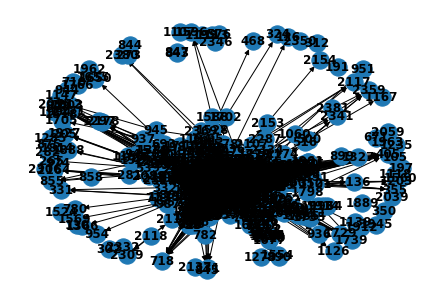

In [40]:
nx.draw(G, with_labels=True, font_weight='bold')

In [41]:
model = DeepWalk(G, walk_length=10, num_walks=80, workers=1)
# 使用word2vec进行training
model.train(window_size=5, iter=3)
embeddings = model.get_embeddings()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


Learning embedding vectors...
Learning embedding vectors done!


Training classifier using 80.00% nodes...
-------------------
{'micro': 0.6923076923076923, 'macro': 0.6130124777211772, 'samples': 0.6923076923076923, 'weighted': 0.690297380929324, 'acc': 0.6923076923076923}


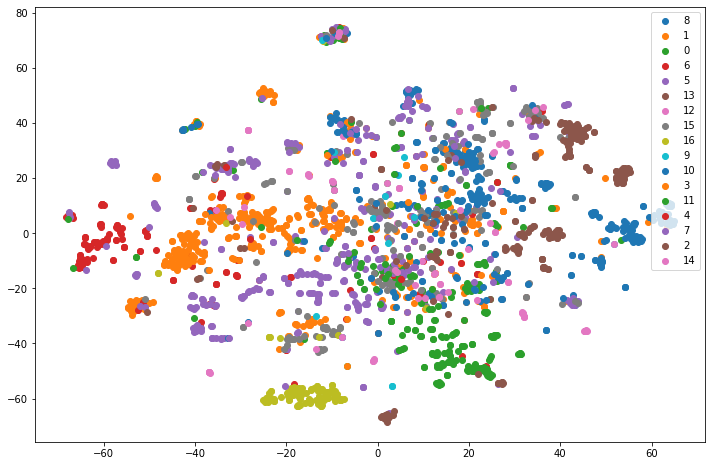

In [42]:
evaluate_embeddings(embeddings)
plot_embeddings(embeddings)

# 参考
[NetworkX](https://www.osgeo.cn/networkx/tutorial.html#analyzing-graphs)  
[【Graph Embedding】DeepWalk：算法原理，实现和应用](https://zhuanlan.zhihu.com/p/56380812)  
[[Python聚类] 用TSNE进行数据降维并展示聚类结果](https://blog.csdn.net/sinat_25873421/article/details/80643377?utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromMachineLearnPai2%7Edefault-2.control&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromMachineLearnPai2%7Edefault-2.control)  
[sklearn中tsne可视化](https://www.deeplearn.me/2137.html)  
[使用Joblib并行运行Python代码](https://juejin.cn/post/6844903839775080456)  
[Python chain函数的用法](https://blog.csdn.net/smart_liu8/article/details/81708620?utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromMachineLearnPai2%7Edefault-1.control&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromMachineLearnPai2%7Edefault-1.control)  
[【论文笔记】DeepWalk](https://zhuanlan.zhihu.com/p/45167021)